In [1]:
import torch
import torchaudio
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torchaudio.functional as F
from IPython.display import Audio, display
import random
import os
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Load the dataset
dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./",
                                             download=True)

# Check how many samples in the dataset
print("Number of samples:", len(dataset))
print(dataset[100000])

# Access a sample
waveform, sample_rate, label,speaker_id, utterance_number = dataset[100000]

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)
print("Label:", label)
print("Speaker ID:", speaker_id)
print("Utterance number:", utterance_number)

cuda


100%|██████████| 2.26G/2.26G [00:18<00:00, 129MB/s]


Number of samples: 105829
(tensor([[0.0001, 0.0002, 0.0002,  ..., 0.0016, 0.0014, 0.0011]]), 16000, 'yes', '94d370bf', 2)
Waveform shape: torch.Size([1, 16000])
Sample rate: 16000
Label: yes
Speaker ID: 94d370bf
Utterance number: 2


In [2]:
# List of desired 10 subclasses
wanted_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# Custom filtered dataset
class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        self._walker = [w for w in self._walker if self._get_label(w) in wanted_words]

    def _get_label(self, fileid):
        return Path(fileid).parent.name

    def __getitem__(self, n):
        waveform, sample_rate, label, *_ = super().__getitem__(n)
        return waveform, sample_rate, label

# Replace the original dataset with the filtered one
dataset = SubsetSC()
print(len(dataset))

38546


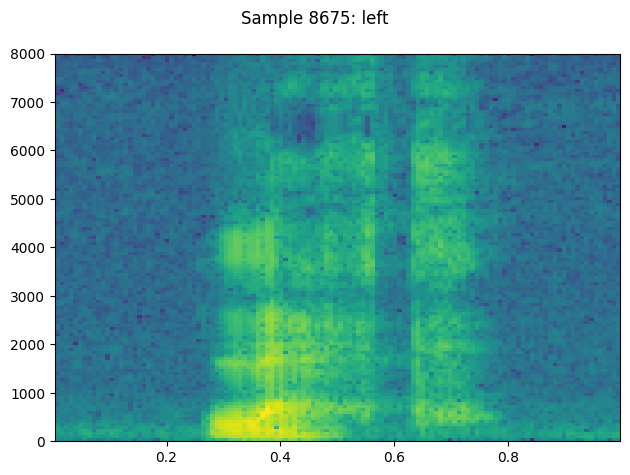

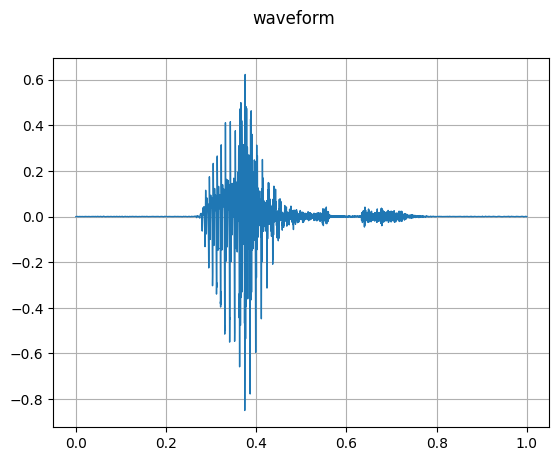

In [3]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

i = random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
display(Audio(waveform.numpy(), rate=sample_rate))
plot_waveform(waveform, sample_rate)

In [4]:
waveform, sample_rate, label= dataset[1]
print("Sample rate:", sample_rate)

Sample rate: 16000


In [11]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=512,
    n_mels=64
).to(device)
db_transform = T.AmplitudeToDB().to(device)

def extract_features(waveform):
    mel_spec = mel_spectrogram(waveform)
    log_mel = db_transform(mel_spec)
    return log_mel


In [7]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

target_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_to_index = {label: i for i, label in enumerate(target_labels)}

def label_filter(label):
    return label in target_labels

def label_to_id(label):
    return label_to_index[label]

def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise
def time_stretch(waveform, rate=1.1):
    return torchaudio.functional.resample(waveform, orig_freq=16000, new_freq=int(16000 * rate))
def data_augmentation(waveform, sample_rate=16000):
    if torch.rand(1).item() < 0.5:
        waveform = add_noise(waveform, noise_level=0.01)
    if torch.rand(1).item() < 0.3:
        steps = torch.randint(-2, 3, (1,)).item()  # -2 to +2
    return waveform

class SubsetDataset(torch.utils.data.Dataset):
    def __init__(self, subset="training", transform=None, max_length=16000):
        self.data = SubsetSC(subset=subset)
        self.transform = transform
        self.max_length = max_length
        self.augment = self.augment = (subset == "training")

        self.training = (subset == "training")
        self.samples = [(waveform, sample_rate, label) for (waveform, sample_rate, label, *_)
                        in self.data if label_filter(label)]

    def pad_or_truncate(self, waveform):
        length = waveform.shape[1]
        if length > self.max_length:
            return waveform[:, :self.max_length]
        elif length < self.max_length:
            pad_amt = self.max_length - length
            return torch.nn.functional.pad(waveform, (0, pad_amt))
        return waveform

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]

        if self.augment and self.training:
            waveform = data_augmentation(waveform, sample_rate)

        waveform = self.pad_or_truncate(waveform)
        waveform=waveform.to(device)
        if self.transform:
            waveform = self.transform(waveform)
            waveform = waveform.squeeze(0).transpose(0, 1)
        return waveform, label_to_id(label)

    def __len__(self):
        return len(self.samples)

train_dataset = SubsetDataset(subset="training", transform=extract_features)
val_dataset = SubsetDataset(subset="validation", transform=extract_features)
test_dataset= SubsetDataset(subset="testing", transform=extract_features)

In [8]:
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    return waveforms, torch.tensor(labels)

In [9]:

batch_size=100
train_loader= DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
test_loader= DataLoader(test_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_fn)
val_dataloader= DataLoader(val_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_fn)

In [12]:
img, label= train_dataset[0]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[-35.4355, -37.8320, -42.8111,  ..., -53.7843, -59.3041, -62.7916],
        [-44.6709, -39.0299, -38.6811,  ..., -52.2918, -60.9240, -60.1253],
        [-33.4900, -38.7916, -40.6048,  ..., -57.5709, -60.6707, -62.1729],
        ...,
        [-14.4287, -13.9549, -13.1884,  ..., -45.1312, -53.5711, -61.9860],
        [-20.2621, -29.6984, -28.6542,  ..., -43.7442, -52.5490, -60.9097],
        [-24.7252, -20.1589, -23.2825,  ..., -44.3130, -50.7435, -63.1094]],
       device='cuda:0')
Image shape: torch.Size([32, 64])
Image datatype: torch.float32
Image label: 3
Label datatype: <class 'int'>


In [13]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.lstm_input_size = None  # Will set later based on actual input
        self.lstm = None  # placeholder
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, T, M)
        x = self.conv(x)    # (B, C, T', M')
        B, C, T, M = x.shape
        x = x.permute(0, 2, 1, 3).reshape(B, T, C * M)  # (B, T, C*M)

        # Lazy initialization of LSTM input size
        if self.lstm is None:
            self.lstm_input_size = C * M
            self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=128, batch_first=True).to(x.device)

        output, _ = self.lstm(x)
        return self.fc(output[:, -1, :])



Epoch 1/20 - Train Loss: 1.9124, Acc: 34.74%, Val Loss: 1.5285, Acc: 49.12%
Epoch 2/20 - Train Loss: 1.4007, Acc: 53.48%, Val Loss: 1.2150, Acc: 58.74%
Epoch 3/20 - Train Loss: 1.1709, Acc: 61.06%, Val Loss: 1.0101, Acc: 65.03%
Epoch 4/20 - Train Loss: 1.0343, Acc: 65.48%, Val Loss: 0.8909, Acc: 69.13%
Epoch 5/20 - Train Loss: 0.9514, Acc: 67.90%, Val Loss: 0.8044, Acc: 72.08%
Epoch 6/20 - Train Loss: 0.8865, Acc: 69.95%, Val Loss: 0.7767, Acc: 73.05%
Epoch 7/20 - Train Loss: 0.8438, Acc: 71.43%, Val Loss: 0.7135, Acc: 75.86%
Epoch 8/20 - Train Loss: 0.8095, Acc: 72.48%, Val Loss: 0.6996, Acc: 75.78%
Epoch 9/20 - Train Loss: 0.7921, Acc: 72.92%, Val Loss: 0.6671, Acc: 77.21%
Epoch 10/20 - Train Loss: 0.7610, Acc: 74.00%, Val Loss: 0.6572, Acc: 77.69%
Epoch 11/20 - Train Loss: 0.7401, Acc: 74.67%, Val Loss: 0.6146, Acc: 79.10%
Epoch 12/20 - Train Loss: 0.7239, Acc: 75.22%, Val Loss: 0.6096, Acc: 79.56%
Epoch 13/20 - Train Loss: 0.7060, Acc: 75.92%, Val Loss: 0.5990, Acc: 79.64%
Epoch 14

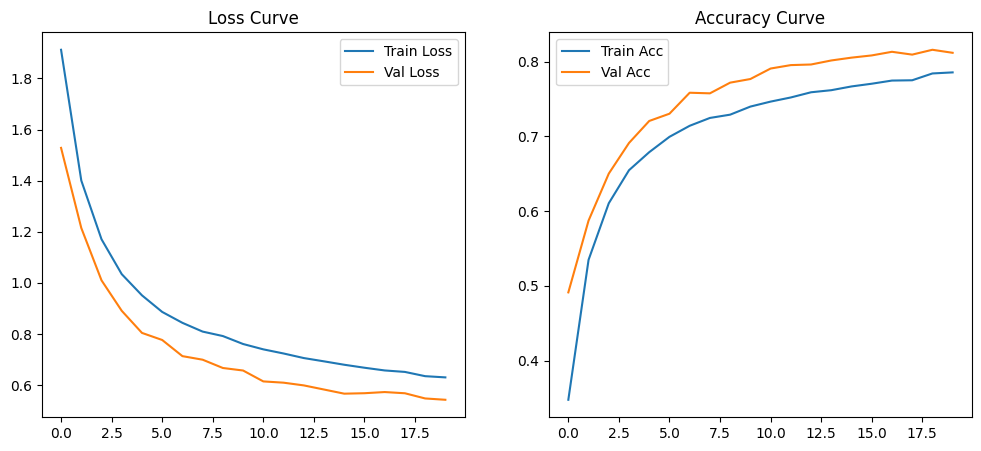

Test Accuracy: 81.15%
F1 Score: 0.8103


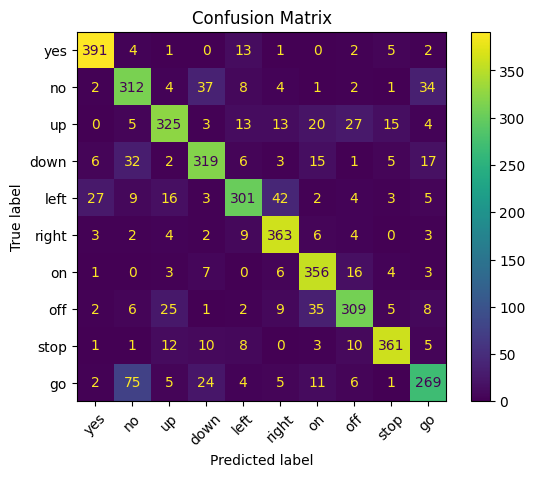

In [14]:

def train_eval(model, train_loader, val_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pred = output.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
                pred = output.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]*100:.2f}%, Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

# Instantiate and train
model = CNNLSTM(num_classes=10).to(device)
train_losses, val_losses, train_accs, val_accs = train_eval(model, train_loader, val_dataloader, epochs=20)

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Final test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        output = model(x)
        preds = output.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=wanted_words)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()